In [1]:
import sys
sys.executable

'/Users/adarsh/Desktop/Facial-Expression-Recognition-Using-Attention-Technique/.venv/bin/python'

In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras import optimizers

In [3]:
conv_base = VGG16(weights='imagenet',
                  include_top = False,
                  input_shape = (48,48,3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

### Analysis with using small number of data only

In [2]:
train_dir = "../Data/fer2013_small/train/"
validation_dir = "../Data/fer2013_small/validation/"

In [5]:
# Image Data Generator setup
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (48, 48),
    batch_size = 50,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (48, 48),
    batch_size = 20,
    class_mode = 'categorical'
)

Found 3436 images belonging to 7 classes.
Found 1256 images belonging to 7 classes.


In [6]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3591      
Total params: 14,980,935
Trainable params: 14,980,935
Non-trainable params: 0
_________________________________________________________________


In [10]:
print("Number of trainable weights before freezing the conv base:", len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 30


In [11]:
conv_base.trainable = False

In [12]:
print("Number of trainable weights after freezing the conv base:", len(model.trainable_weights))

Number of trainable weights after freezing the conv base: 4


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-4),
              metrics = ['accuracy']
             )

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=68,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=62
)

Epoch 1/10
44/68 [==================>...........] - ETA: 43s - loss: 1.8273 - accuracy: 0.2758

### Using Pretrained network to extract features on whole data

In [33]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [30]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [31]:
base_dir = "../Data/fer2013/"
train_dir = "../Data/fer2013/Training/"
validation_dir = "../Data/fer2013/PublicTest/"

In [47]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10

In [50]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 512))
    labels = np.zeros(shape=(sample_count, 7))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(48,48),
        batch_size=batch_size,
        class_mode='categorical'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i+=1
        if i*batch_size >= sample_count:
            break
    return features, labels

In [37]:
train_features, train_labels = extract_features(train_dir, 28799)

Found 28799 images belonging to 7 classes.


In [38]:
train_features.shape

(28799, 1, 1, 512)

In [39]:
train_labels.shape

(28799, 7)

In [51]:
validation_features, validation_labels = extract_features(validation_dir, 3589)

Found 3589 images belonging to 7 classes.


In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

In [53]:
train_features = np.reshape(train_features, (28799, 1*1*512))
validation_features = np.reshape(validation_features, (3589, 1*1*512))

In [66]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=512))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-04),
              metrics=['accuracy']
             )

In [67]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 1799      
Total params: 198,919
Trainable params: 198,919
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(train_features,
                    train_labels,
                    batch_size=20,
                    epochs=40,
                    validation_data=(validation_features, validation_labels)
                   )

Epoch 1/40
1440/1440 [==============================] - 6s 4ms/step - loss: 1.7461 - accuracy: 0.2879 - val_loss: 1.6768 - val_accuracy: 0.3293
Epoch 2/40
1440/1440 [==============================] - 6s 4ms/step - loss: 1.6862 - accuracy: 0.3227 - val_loss: 1.6566 - val_accuracy: 0.3441
Epoch 3/40
1440/1440 [==============================] - 6s 4ms/step - loss: 1.6653 - accuracy: 0.3312 - val_loss: 1.6395 - val_accuracy: 0.3461
Epoch 4/40
1440/1440 [==============================] - 7s 5ms/step - loss: 1.6562 - accuracy: 0.3392 - val_loss: 1.6330 - val_accuracy: 0.3516
Epoch 5/40
1440/1440 [==============================] - 6s 4ms/step - loss: 1.6513 - accuracy: 0.3430 - val_loss: 1.6247 - val_accuracy: 0.3592
Epoch 6/40
1440/1440 [==============================] - 6s 4ms/step - loss: 1.6449 - accuracy: 0.3454 - val_loss: 1.6299 - val_accuracy: 0.3617
Epoch 7/40
1440/1440 [==============================] - 6s 4ms/step - loss: 1.6407 - accuracy: 0.3471 - val_loss: 1.6183 - val_accuracy:

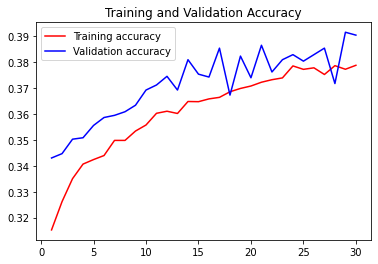

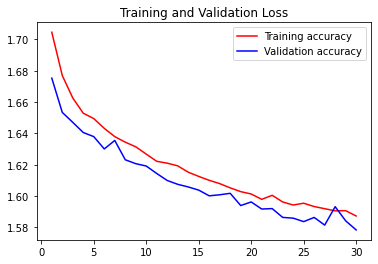

In [61]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label="Training accuracy")
plt.plot(epochs, val_loss, 'b', label="Validation accuracy")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

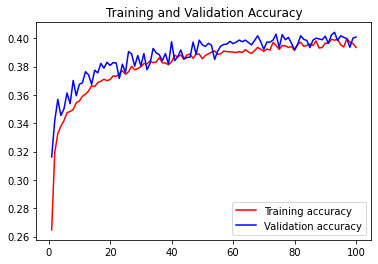

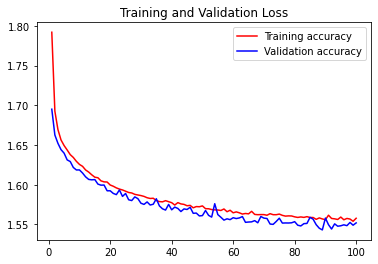

In [65]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label="Training accuracy")
plt.plot(epochs, val_loss, 'b', label="Validation accuracy")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

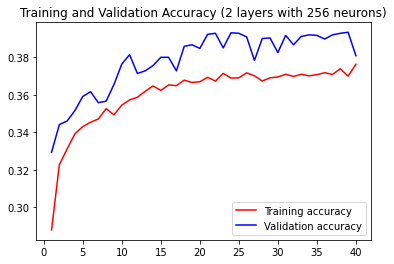

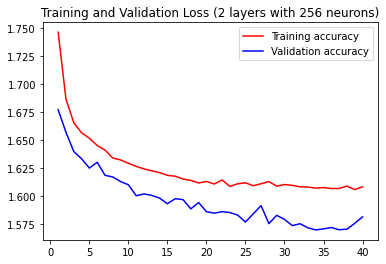

In [70]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title('Training and Validation Accuracy (2 layers with 256 neurons)')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label="Training accuracy")
plt.plot(epochs, val_loss, 'b', label="Validation accuracy")
plt.title('Training and Validation Loss (2 layers with 256 neurons)')
plt.legend()
plt.show()